In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow.keras as tfk
from tensorflow.keras import layers as tfk_layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import  Dense, Conv2D, MaxPool2D, MaxPooling2D, Flatten
from tensorflow.keras import optimizers
from tensorflow.keras import layers
import sys
from scipy.stats import mode

In [2]:
# '''
# Some code modified from that provided by Daniel Sawyer.  This implementation
# is done with functions for a different look.  You do not have to use it.
# You will work with cifar100 as set up here (in terms of train, validation
# and test).  This is color images of size 32x32 of 100 classes. Hence, 3
# chanels R, G, B. I took out 10% for validation.
# You can change this around, but must be very clear on what was done and why.
# You must improve on 44% accuracy (which is a fairly low bar).  You need to
# provide a best class accuracy and worst class accuracy. To improve, more epochs
# can help, but that cannot be the only change you make.  You should show  better
# performance at 15 epochs or argue why it is not possible.  You can add layers,
# subtract layers (though you have 100 classes). You need to report on the number
# of examples.

# I also want you to use a snapshot ensemble of at least 5 snapshots.  One
# way to choose the best class is to sum the per class outputs and take the
# maximum.  Another is to vote for the class and break ties in some way.
# Indicate if results are better or worse or the same. (This is 5
# extra credit points of the grade).

# You must clearly explain what you tried and why and what seemed to work
# and what did not.  That will be the major part of your grade.  Higher
# accuracy will also improve your grade. If you use an outside source, it
# must be disclosed and that source may be credited with part of the grade.
#  The best accuracy in class will add
# 3 points to their overall average grade, second best 2 points and 3rd best
#  1 point.

# To get predictions:
# predictions=model.predict(ds_test)
# Prints the first test predition and you will see 100 predictions
# print(predictions[0])

# '''

In [3]:
def normalize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    return tf.cast(image, tf.float32) / 255., label


def loadmycifar100():
  # cifar100 has 2 sets of labels.  The default is "label" giving you 100
  # predictions for the classes
  (ds_train, dsvalid, ds_test), ds_info = tfds.load(
    'cifar100',
  # First 35% and last 55% from training, then validation data is 10%
  # from 35% of train data to 41+% and test is the usual 10K
    split=['train[:35%]+train[-55%:]','train[35%:45%]', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
  )
  ds_train = ds_train.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  dsvalid = dsvalid.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  ds_test = ds_test.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)

  #tf.keras.datasets.cifar100.load_data(label_mode="fine")


  #  ds_train = ds_train.map(
  #    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  ds_train = ds_train.cache()
  ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
  ds_train = ds_train.batch(128)
  ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

#  ds_test = ds_test.map(
#    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  ds_test = ds_test.batch(128)
  ds_test = ds_test.cache()
  ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)


#  dsvalid = dsvalid.map(
#    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  dsvalid = dsvalid.batch(64)
  dsvalid = dsvalid.cache()
  dsvalid = dsvalid.prefetch(tf.data.experimental.AUTOTUNE)
  return ds_train, dsvalid, ds_test

In [4]:
# Loads data
(ds_train, dsvalid, ds_test) = loadmycifar100()

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar100/3.0.2.incompleteF8PZZU/cifar100-train.tfrecord*...:   0%|        …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar100/3.0.2.incompleteF8PZZU/cifar100-test.tfrecord*...:   0%|         …

Dataset cifar100 downloaded and prepared to /root/tensorflow_datasets/cifar100/3.0.2. Subsequent calls will reuse this data.


First let's change the model architecture and show the results for one model. Later, we will use ensembles and check if the accuracy improves.

In [5]:
def residual_block(x, filters, kernel_size=3):
    # Shortcut
    shortcut = x

    # First layer
    x = tfk_layers.Conv2D(filters, kernel_size, padding='same')(x)
    x = tfk_layers.BatchNormalization()(x)
    x = tfk_layers.Activation('relu')(x)

    # Second layer
    x = tfk_layers.Conv2D(filters, kernel_size, padding='same')(x)
    x = tfk_layers.BatchNormalization()(x)

    # Adding the shortcut to the output of the block
    x = tfk_layers.Add()([shortcut, x])
    x = tfk_layers.Activation('relu')(x)

    return x

def build_model():
    # Input shape and layer
    input_shape = (32, 32, 3)
    input_layer = tfk_layers.Input(shape=input_shape)

    # First convolution, batch norm
    ly = tfk_layers.Conv2D(32, 3)(input_layer)
    ly = tfk_layers.BatchNormalization()(ly)
    ly = tfk_layers.Activation('relu')(ly)

    ly = tfk_layers.MaxPooling2D()(ly)

    # Second convolution, batch norm
    ly = tfk_layers.Conv2D(128, 3)(ly)
    ly = tfk_layers.BatchNormalization()(ly)
    ly = tfk_layers.Activation('relu')(ly)

    # Third convolution, batch norm
    ly = tfk_layers.Conv2D(256, 3)(ly)
    ly = tfk_layers.BatchNormalization()(ly)
    ly = tfk_layers.Activation('relu')(ly)

    # Adding a residual block
    ly = residual_block(ly, 256)

    # Max pooling layer and flattens for dense layers
    ly = tfk_layers.MaxPooling2D()(ly)
    ly = tfk_layers.Flatten()(ly)

    # First dense layer with batch norm & dropout
    ly = tfk_layers.Dense(512)(ly)
    ly = tfk_layers.BatchNormalization()(ly)
    ly = tfk_layers.Activation('relu')(ly)
    ly = tfk_layers.Dropout(0.5)(ly)

    # Output dense layer, 100 classes
    ly = tfk_layers.Dense(100)(ly)
    output_layer = tfk_layers.Activation('softmax')(ly)

    model = tf.keras.Model(input_layer, output_layer)

    return model


In [6]:
runs = 5
epochs = 15

In [7]:
# show model architecture
model = build_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 30, 30, 32)           896       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 30, 30, 32)           128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 30, 30, 32)           0         ['batch_normalization[0][0

In [8]:
for run in range(runs):
  print(f"[=========== run: {run + 1}/{runs} ===========]")
  # Callback for saving best epoch checkpoint weights for each run
  model_path = f'cifar100_best_ckeckpt_run{run}.h5'
  checkpoint = tfk.callbacks.ModelCheckpoint(
    filepath=model_path,
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True
  )

  callbacks = [checkpoint]

  # Compiles model with adam optimizer
  model = build_model()
  opt = tfk.optimizers.Adam(learning_rate=0.001)
  model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
    )
  # Trains model with increased epochs and saves best
  model.fit(
    ds_train,
    epochs=epochs,
    validation_data=dsvalid,
    callbacks=callbacks
    )

[=========== run: 1/5 ===========]
Epoch 1/15
352/352 [==============================] - ETA: 0s - loss: 3.6237 - accuracy: 0.1655
Epoch 1: val_accuracy improved from -inf to 0.07940, saving model to cifar100_best_ckeckpt_run0.h5
352/352 [==============================] - 35s 41ms/step - loss: 3.6237 - accuracy: 0.1655 - val_loss: 4.5522 - val_accuracy: 0.0794
Epoch 2/15


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


352/352 [==============================] - ETA: 0s - loss: 2.6780 - accuracy: 0.3250
Epoch 2: val_accuracy improved from 0.07940 to 0.29140, saving model to cifar100_best_ckeckpt_run0.h5
352/352 [==============================] - 12s 35ms/step - loss: 2.6780 - accuracy: 0.3250 - val_loss: 2.8451 - val_accuracy: 0.2914
Epoch 3/15
351/352 [============================>.] - ETA: 0s - loss: 2.2390 - accuracy: 0.4159
Epoch 3: val_accuracy improved from 0.29140 to 0.34280, saving model to cifar100_best_ckeckpt_run0.h5
352/352 [==============================] - 12s 35ms/step - loss: 2.2394 - accuracy: 0.4158 - val_loss: 2.5526 - val_accuracy: 0.3428
Epoch 4/15
351/352 [============================>.] - ETA: 0s - loss: 1.9235 - accuracy: 0.4846
Epoch 4: val_accuracy improved from 0.34280 to 0.42180, saving model to cifar100_best_ckeckpt_run0.h5
352/352 [==============================] - 12s 35ms/step - loss: 1.9241 - accuracy: 0.4844 - val_loss: 2.2391 - val_accuracy: 0.4218
Epoch 5/15
351/352

# Things that helped
- Adding a skip connection + depth increased the accuracy.

# Things that didn't help
Changing the activation function to `elu` lowered the test accuracy.


In [9]:
def accuracy(y_pred, y_true):
  return np.mean(y_pred == y_true)

In [10]:
def ensemble(logits, method='sum'):
  """ logits: a list of predictions for each model """

  if method == "sum":
    return np.sum(logits_list, axis=0).argmax(axis=-1)
  elif method == "mode":
    y_pred = []
    for _logits in logits:
      # make a prediction for each model
      y_pred.append(_logits.argmax(axis=-1))  # (N,)
    y_pred = np.stack(y_pred, axis=-1) # (N, num_ensembles)
    y_pred = mode(y_pred, axis=-1).mode
    return y_pred
  else:
    raise NotImplementedError("Ensemble method not implemented.")


In [11]:
model = build_model()
logits_list = []
for run in range(runs):
  # Load best model weights for each run
  model_path = f'cifar100_best_ckeckpt_run{run}.h5'
  model.load_weights(model_path)
  logits = model.predict(ds_test, batch_size=128)
  logits_list.append(logits)

79/79 [==============================] - 1s 9ms/step


In [12]:
# collect ground truth labels
y_true = []
for _, labels in ds_test:
    y_true.append(labels.numpy())
y_true = np.concatenate(y_true, axis=0)

In [13]:
for method in ["sum", "mode"]:
  y_pred = ensemble(logits_list, method)
  acc = accuracy(y_pred, y_true)
  print("Ensemble method: {} \t accuracy: {}".format(method, acc))

Ensemble method: sum 	 accuracy: 0.5815
Ensemble method: mode 	 accuracy: 0.5611


# Class-wise accuracy

In [14]:
num_classes = 100
class_wise_preds = [[] for _ in range(num_classes)]

for pred, label in zip(y_pred, y_true):
  class_wise_preds[label].append(pred)


class_wise_acc = [0] * 100

for i, class_preds in enumerate(class_wise_preds):
  y_true = np.array([i] * len(class_preds))
  y_pred = np.array(class_preds)
  acc = accuracy(y_pred, y_true)
  class_wise_acc[i] = acc


class_wise_acc = np.array(class_wise_acc)
cls_min_acc, cls_max_acc = np.argmin(class_wise_acc), np.argmax(class_wise_acc)

In [15]:
print(f"minimum accuracy (class {cls_min_acc}): {class_wise_acc[cls_min_acc]}  Maximum accuracy (class {cls_max_acc}): {class_wise_acc[cls_max_acc]}.")

minimum accuracy (class 55): 0.18  Maximum accuracy (class 53): 0.87.


In [16]:
import matplotlib.pyplot as plt

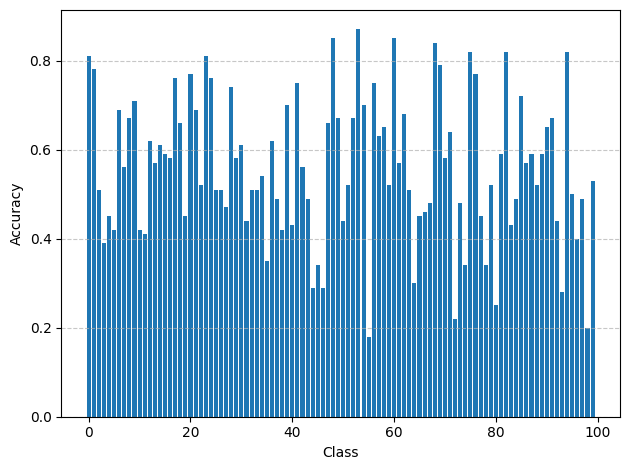

In [17]:
plt.bar(range(100), class_wise_acc)
plt.xlabel("Class")
plt.ylabel("Accuracy")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()